XG BOOST WITHOUT TIME SPLIT

In [ ]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load dataset
data_path = "/content/Ayurveda Dataset.csv"
df = pd.read_csv(data_path, parse_dates=['Date'])

df.sort_values(by='Date', inplace=True)  # Ensure chronological order


In [ ]:
# Convert 'Total_Arrivals' to numeric, removing commas
df['Total_Arrivals'] = pd.to_numeric(df['Total_Arrivals'].str.replace(',', ''), errors='coerce')


In [ ]:

df['Lag1'] = df['Total_Arrivals'].shift(1)
df['Lag2'] = df['Total_Arrivals'].shift(2)
df['Rolling_Mean_12'] = df['Total_Arrivals'].rolling(window=12, min_periods=1).mean()
df.dropna(inplace=True)  # Drop rows with NaN values after feature creation

In [ ]:


# Check for missing values in the DataFrame
missing_values = df.isnull().sum()
print(missing_values)
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage


Date                 0
Year                 0
Month                0
Total_Arrivals       0
Ayurveda_Tourists    0
Lag1                 0
Lag2                 0
Rolling_Mean_12      0
dtype: int64


,0
Date,0.0
Year,0.0
Month,0.0
Total_Arrivals,0.0
Ayurveda_Tourists,0.0
Lag1,0.0
Lag2,0.0
Rolling_Mean_12,0.0


In [ ]:
df.head()

,Date,Year,Month,Total_Arrivals,Ayurveda_Tourists,Lag1,Lag2,Rolling_Mean_12
2,2007-03-31,2007,3,1333.298584,210.771883,1126.969808,1173.041803,1211.103398
3,2007-04-30,2007,4,1605.481259,250.765090,1333.298584,1126.969808,1309.697864
4,2007-05-31,2007,5,1693.388378,146.351783,1605.481259,1333.298584,1386.435966
5,2007-06-30,2007,6,1028.730392,202.654745,1693.388378,1605.481259,1326.818371
6,2007-07-31,2007,7,1984.684939,146.461502,1028.730392,1693.388378,1420.799309


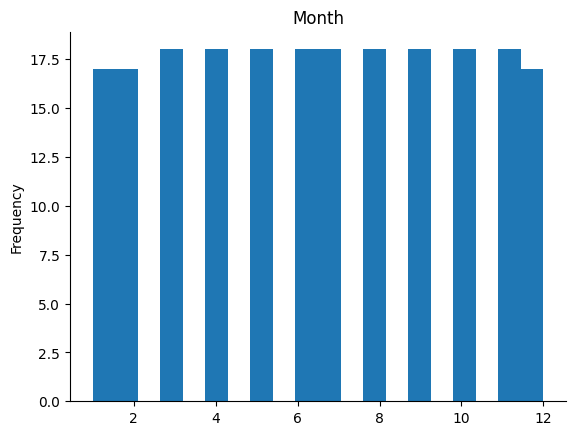

In [ ]:
# @title Month

from matplotlib import pyplot as plt
df['Month'].plot(kind='hist', bins=20, title='Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

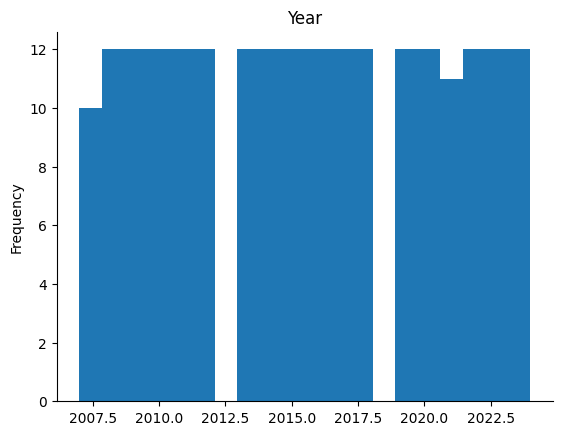

In [ ]:
# @title Year

from matplotlib import pyplot as plt
df['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

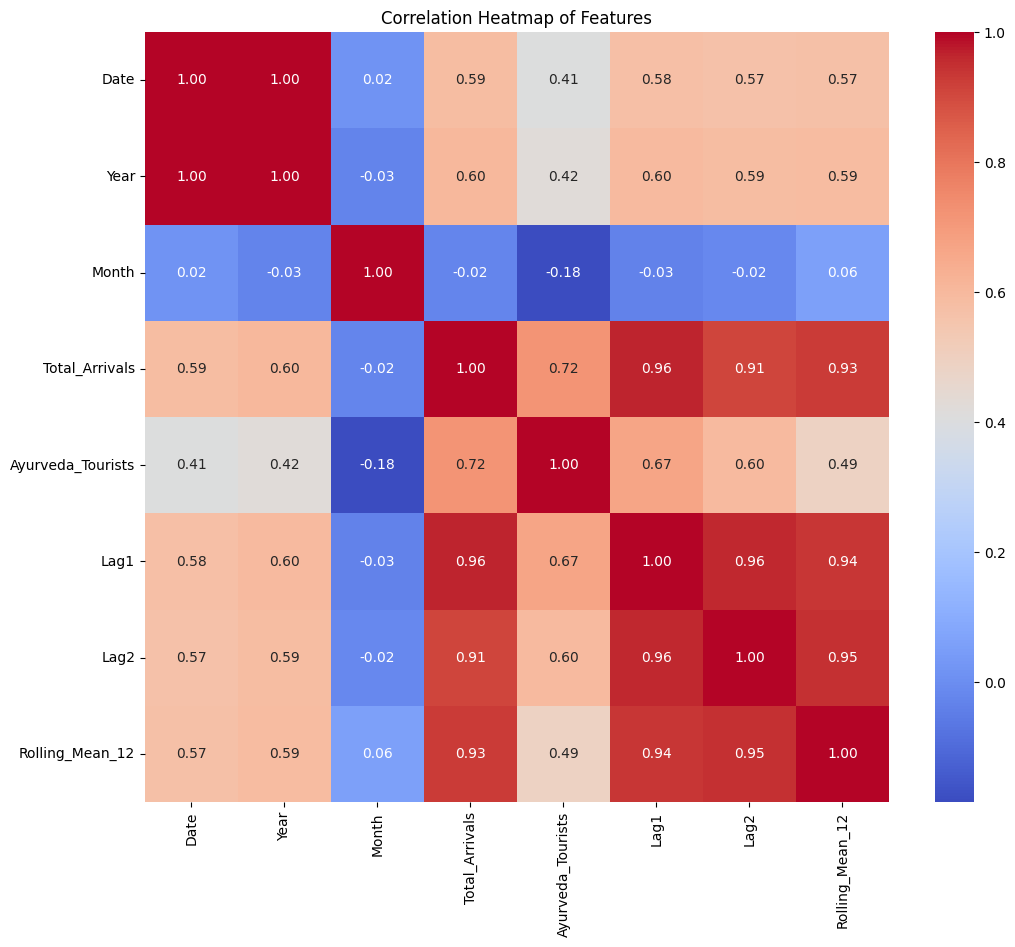

In [ ]:
import matplotlib.pyplot as plt
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()


In [ ]:
# Define features and target
features = ['Lag1', 'Lag2', 'Rolling_Mean_12', 'Month', 'Year']
target = 'Ayurveda_Tourists'

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# prompt: how to check the scaled values

# Print the first few scaled training examples
print(X_train_scaled[:5])

# Print the first few scaled testing examples
print(X_test_scaled[:5])


[[-0.35620512 -0.36635617 -0.35627617  1.06075136 -0.44838392]
 [-0.36086777 -0.36056028 -0.35491415  0.47810926  0.93036766]
 [-0.36189909 -0.35927734 -0.35273293 -0.68717495  0.14250962]
 [-0.36901112 -0.35834886 -0.35745123  1.06075136  0.33947413]
 [-0.36470897 -0.35046542 -0.35296695 -1.26981706 -0.05445489]]
[[-0.36510264 -0.35608202 -0.35325451  1.64339346 -1.63017098]
 [ 2.7871528   2.87550297  2.26993594  0.76943031  1.5212612 ]
 [-0.3575837  -0.36744275 -0.35409038  0.76943031 -0.64534843]
 [ 2.11609003  1.95035837  1.3021696  -0.978496    1.5212612 ]
 [-0.37060416 -0.36300156 -0.35312541  1.64339346  0.14250962]]


In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
# Pass eval_metric within eval_set
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=True)

results = xgb_model.evals_result()
# Extract loss values
train_loss = results['validation_0']['rmse']  # Training loss (RMSE)
val_loss = results['validation_1']['rmse']    # Validation loss (RMSE)

# Print final training and validation loss
print(f"Final Training Loss (RMSE): {train_loss[-1]}")
print(f"Final Validation Loss (RMSE): {val_loss[-1]}")


# Model evaluation
y_pred = xgb_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

[0]	validation_0-rmse:266.01566	validation_1-rmse:371.85466
[1]	validation_0-rmse:246.93073	validation_1-rmse:345.40386
[2]	validation_0-rmse:229.68696	validation_1-rmse:321.91188
[3]	validation_0-rmse:214.10568	validation_1-rmse:301.12980
[4]	validation_0-rmse:200.02794	validation_1-rmse:284.83678
[5]	validation_0-rmse:187.15924	validation_1-rmse:268.57973
[6]	validation_0-rmse:175.45940	validation_1-rmse:254.27104
[7]	validation_0-rmse:164.93843	validation_1-rmse:240.24902
[8]	validation_0-rmse:155.33224	validation_1-rmse:231.91025
[9]	validation_0-rmse:145.96706	validation_1-rmse:223.34698
[10]	validation_0-rmse:137.98164	validation_1-rmse:218.07270
[11]	validation_0-rmse:130.87869	validation_1-rmse:213.57933
[12]	validation_0-rmse:122.91973	validation_1-rmse:203.93079
[13]	validation_0-rmse:116.00769	validation_1-rmse:198.57690
[14]	validation_0-rmse:109.33682	validation_1-rmse:190.60784
[15]	validation_0-rmse:103.71759	validation_1-rmse:185.30411
[16]	validation_0-rmse:98.05728	va

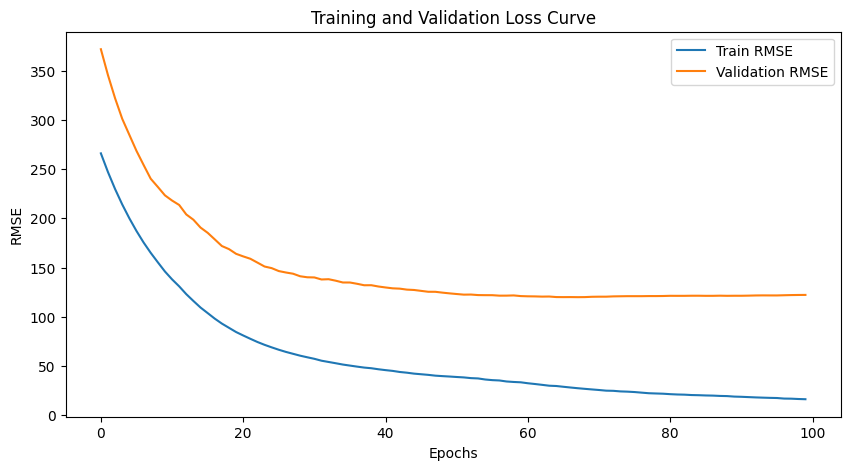

In [ ]:
# Plot Training and Validation Loss Curve
results = xgb_model.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

MSE: 14921.535045079265
MAE: 88.51679404817256
R²: 0.9045554104519797


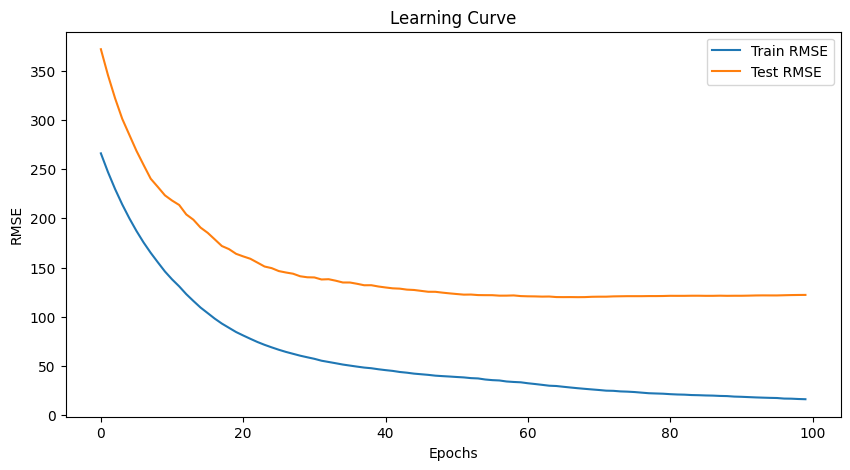

In [ ]:
# Learning Curves

plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['rmse'], label='Train RMSE')
plt.plot(results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()

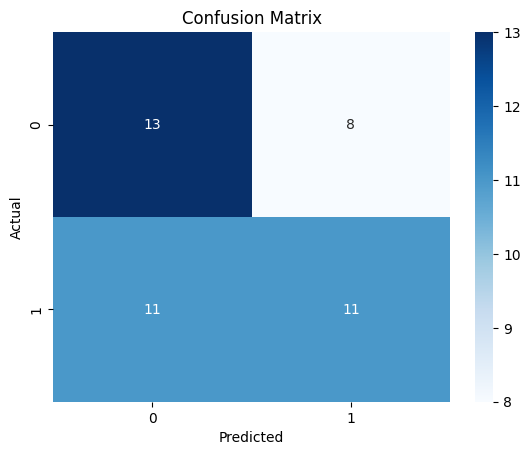

In [ ]:
# Confusion Matrix (for classification-like visualization)
threshold = np.median(y_test)
y_pred_binary = (y_pred >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the trained model
joblib.dump(xgb_model, 'final_xgboost_modell.pkl')
print("Model saved as final_xgboost_modell.pkl")

Model saved as final_xgboost_modell.pkl


In [ ]:
# prompt: save the updated dataset

# Save the updated DataFrame
df.to_csv('updated_dataset.csv', index=False)
print("Updated dataset saved as updated_dataset.csv")


Updated dataset saved as updated_dataset.csv


SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define SARIMA model (order=(p,d,q), seasonal_order=(P,D,Q,s))
sarima_model = SARIMAX(df['Ayurveda_Tourists'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

# Forecast for test period
y_pred_sarima = sarima_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Evaluate SARIMA
mse_sarima = mean_squared_error(y_test, y_pred_sarima)
mae_sarima = mean_absolute_error(y_test, y_pred_sarima)
r2_sarima = r2_score(y_test, y_pred_sarima)

print(f"SARIMA - MSE: {mse_sarima}, MAE: {mae_sarima}, R²: {r2_sarima}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA - MSE: 566760.2473045508, MAE: 590.4258645472405, R²: -2.625243583364178


In [ ]:
!pip install pmdarima
import pmdarima as pm

# Automatically find the best parameters for SARIMA
model = pm.auto_arima(df['Ayurveda_Tourists'],
                      seasonal=True,
                      m=12,  # Set m to 12 for yearly seasonality (monthly data)
                      trace=True,  # Print progress
                      suppress_warnings=True)

# Print the best SARIMA order
print(model.summary())

# Fit the model
sarima_result = model.fit(df['Ayurveda_Tourists'])

# Forecast for the test period
y_pred_sarima = sarima_result.predict(n_periods=len(y_test))

# Evaluate the model
mse_sarima = mean_squared_error(y_test, y_pred_sarima)
mae_sarima = mean_absolute_error(y_test, y_pred_sarima)
r2_sarima = r2_score(y_test, y_pred_sarima)

print(f"SARIMA - MSE: {mse_sarima}, MAE: {mae_sarima}, R²: {r2_sarima}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2789.938, Time=6.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2800.275, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2796.527, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2798.500, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2798.281, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2789.123, Time=0.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2791.200, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2789.389, Time=2.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2788.496, Time=1.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2789.442, Time=3.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2791.886, Time=6.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2791.963, Time=0.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2794.793, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2795.088, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=2769.835, Time=5.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=2770.063, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=5.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[12] intercept   : AIC=2769.771, Time=3.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[12] intercept   : AIC=2771.766, Time=3.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=2795.624, Time=0.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=2793.466, Time=1.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[12] intercept   : AIC=2770.464, Time=3.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=2770.769, Time=1.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2794.480, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=2784.500, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,1)[12] intercept   : AIC=2771.986, Time=1.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[12]             : AIC=2768.665, Time=1.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[12]             : AIC=2768.882, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12]             : AIC=2770.658, Time=4.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[12]             : AIC=2770.657, Time=4.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12]             : AIC=2768.730, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[12]             : AIC=inf, Time=3.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12]             : AIC=2793.641, Time=0.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[12]             : AIC=2791.487, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[12]             : AIC=2769.057, Time=0.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[12]             : AIC=2769.301, Time=1.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12]             : AIC=2792.497, Time=1.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12]             : AIC=2787.130, Time=2.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12]             : AIC=2782.524, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,1)[12]             : AIC=2770.641, Time=0.93 sec

Best model:  ARIMA(3,1,1)(0,0,1)[12]          
Total fit time: 89.266 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  213
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1378.332
Date:                            Sun, 16 Mar 2025   AIC                           2768.665
Time:                                    07:27:34   BIC                           2788.804
Sample:                                         0   HQIC                          2776.805
                                            - 213                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


SARIMA - MSE: 188960.0242644134, MAE: 376.7072980953042, R²: -0.20867001299899335


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


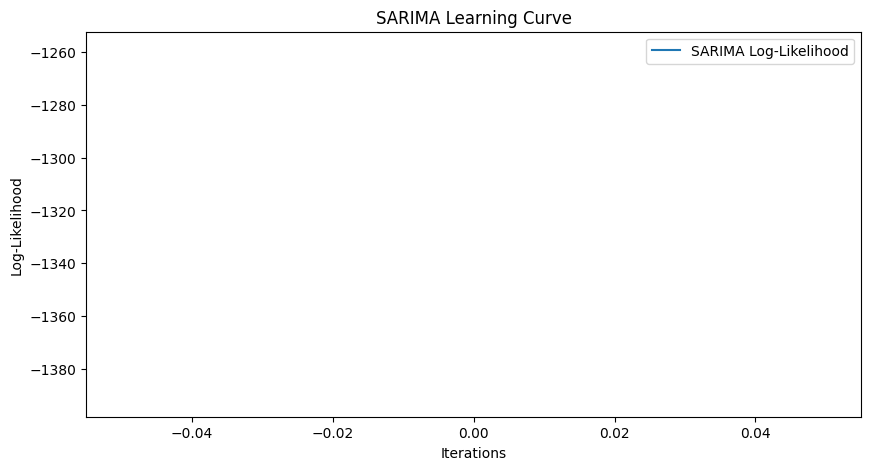

In [ ]:
# Extract training log-likelihood loss
plt.figure(figsize=(10, 5))
plt.plot(sarima_result.llf, label="SARIMA Log-Likelihood")
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.title("SARIMA Learning Curve")
plt.legend()
plt.show()


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
import numpy as np

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}")


# Predict on training data
y_pred_rf_train = rf_model.predict(X_train_scaled)

# Calculate RMSE for training data
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))

# Calculate RMSE for testing data (already calculated as val_loss)
test_rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest Train RMSE: {train_rmse_rf}")
print(f"Random Forest Test RMSE: {test_rmse_rf}")

Random Forest - MSE: 22116.89490889277, MAE: 102.64436653838601, R²: 0.8585307778134996
Random Forest Train RMSE: 63.849027393402835
Random Forest Test RMSE: 148.7175003450931
